Author: Lynn Menchaca

Date: 23Nov2022

Project: Mental Health Classifier from Tweets

Resources:

- Kaggle Data Set: Tweet Mental Health Classification
    - https://www.kaggle.com/competitions/tweet-mental-health-classification/data?select=train.csv
- Youtube: Ken Jee -> Data Science Project from Scratch - Part 4 (Exploratory Data Analysis)
    - https://www.youtube.com/watch?v=QWgg4w1SpJ8&list=PL2zq7klxX5ASFejJj80ob9ZAnBHdz5O1t&index=4
- plot confusion matrix
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
- Multi-Class Text Classification Model Comparison and Selection by Susan Li
    - https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

The purpose of this project is design a model to identify mental health in tweets.

### Project Overview

### Data Processing and Analysis
- Initial Overview: size, collumns, data types, missing values
- Make copy of train data to play with
- Remove duplicate rows
- Clean the tweets
    - Remove any characters that are not letters
    - Removing stop words: and, it, ... (don't have much importance)
    - keep just stem words
- Create a word cloud for each Mental Health Label

### Machine Learning Models:
- Bag of Words Model (Convert strings to a matrix)
    - Count Vectorizer with Tfidf Transformation
    - Tfidf Vectorizer
    - Hashing Vectorizer
- Dependant (X) and Independent (y) variables
- Train Test Split
- ML Models with Hyperparameter Tuning
    - Multinomial NM Algorithm
    - Passivie Aggressive Classifer
    - Linear Support Vector Machine
    - Logistic Regression

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# Data Frames

data_file_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/Tweet_Mental_Health_Data/'
df_test = pd.read_csv(data_file_path+'test.csv')
df_train = pd.read_csv(data_file_path+'train.csv')
df_train.head()

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal


In [3]:
#Overview of data

print('Train Data')
print(df_train.shape)
print(df_train.isnull().sum())
print('\n')
print('test Data')
print(df_test.shape)
print(df_test.isnull().sum())

Train Data
(29992, 2)
tweets    0
labels    0
dtype: int64


test Data
(7499, 2)
id        0
tweets    0
dtype: int64


There is no missing data from both the test and training data. This makes sense since there is only one dependant and independant feature in the training data. If there was any missing data in the training data set the row would have been removed.

In [4]:
print(df_train.dtypes)
print(df_test.dtypes)

tweets    object
labels    object
dtype: object
id         int64
tweets    object
dtype: object


The test and training data do not need to be formated.

In [5]:
#creating a copy of the training data to investigate 
df_tweets = df_train.copy()
# checking for duplicate data in the training data frame.
print(df_tweets[df_tweets.duplicated()])
print('number of duplicate rows: ', df_tweets[df_tweets.duplicated()].shape[0])

                                                  tweets    labels
97     human need job cant exist amp make art chill cat    Anxious
116    sad thing disinformation truth come damage alr...  Stressed
146    sad thing disinformation truth come damage alr...  Stressed
164    hi ask kindness might big battle life dad need...   Anxious
168    boy get slaughter helpless mother could scream...  Stressed
...                                                  ...       ...
29985  hey friend need another nominee weekstarcompet...   Anxious
29986  sad newscloris insanely talented could make la...  Stressed
29988  name muhammad asif farooqi im pakistan amp sta...    Lonely
29989  moms mad wont go overnight skiing trip 5 peopl...  Stressed
29991  jps gooooo amp suck yuh madda mi haaaaaaaaaaaa...    Lonely

[10615 rows x 2 columns]
number of duplicate rows:  10615


In [6]:
# Removing the duplicate rows
print('Size of training data before removing duplicate rows: ', df_tweets.shape)
df_tweets.drop_duplicates(keep='first',inplace=True)
print('Size of training data before removing duplicate rows: ', df_tweets.shape)

#Reseting the index since rows were dropped
df_tweets.reset_index(inplace=True)
df_tweets.head()

Size of training data before removing duplicate rows:  (29992, 2)
Size of training data before removing duplicate rows:  (19377, 2)


,index,tweets,labels
0,0,sending solidarity whoever doctor manage incre...,Stressed
1,1,need see hair amp beard gat book appointment b...,Anxious
2,2,next time meet someone new dont ask ask love,Normal
3,3,surprise someone love give la senza gift box r...,Lonely
4,4,raise hand junhoes ocean lotion life rent free...,Normal


In [7]:
df_tweets['labels'].value_counts()

Normal      7340
Anxious     5047
Stressed    3556
Lonely      3434
Name: labels, dtype: int64


The training data does not appear to be unbalanced.


In [8]:
# Removing special characters from text in title column
# Removing stop words: and, it, ... (don't have much importance)

ps = PorterStemmer()
corpus = []
full_corpus_string = ''

for i in range(0, len(df_tweets)):
    #replacing any character that is not a/A through z/Z with a blank - used for split
    tweet = re.sub('[^a-zA-Z]', ' ', df_tweets['tweets'][i])
    #uniforms the list to make it easier to go threw each word
    tweet = tweet.lower()
    #split -> each word in to a list
    tweet = tweet.split()
    
    #checking each character for stem and stopwords
    #removing the stop words then performing the steming process
    tweet = [ps.stem(word) for word in tweet if not word in stopwords.words('english')]
    tweet = ' '.join(tweet)
    corpus.append(tweet)
    full_corpus_string += tweet + ' '

In [9]:
#The remaining words for each row.

corpus[:5]

['send solidar whoever doctor manag incred distress situat calmli disinfo',
 'need see hair amp beard gat book appoint barb meanwhil fit stroll enter pot joint life',
 'next time meet someon new dont ask ask love',
 'surpris someon love give la senza gift box rm join telegram wont miss updat surprisesomeoneyoulov lasenzamalaysia lasenza pslasenza pslasenzakl pslasenzamalaysia personalshopperlasenza',
 'rais hand junho ocean lotion life rent free mind ikon domin stanworldikon']

In [10]:
#All the words as one long string

full_corpus_string[:500]

'send solidar whoever doctor manag incred distress situat calmli disinfo need see hair amp beard gat book appoint barb meanwhil fit stroll enter pot joint life next time meet someon new dont ask ask love surpris someon love give la senza gift box rm join telegram wont miss updat surprisesomeoneyoulov lasenzamalaysia lasenza pslasenza pslasenzakl pslasenzamalaysia personalshopperlasenza rais hand junho ocean lotion life rent free mind ikon domin stanworldikon mariposa de barrio teach matter guy fo'

In [11]:
#create a data frame with cleaned tweets
df_corpus_str = pd.DataFrame(corpus,
                            columns = ['tweets'])
df_corpus_str['labels'] = df_tweets['labels']

print(df_corpus_str.head())
print(df_tweets.head())

                                              tweets    labels
0  send solidar whoever doctor manag incred distr...  Stressed
1  need see hair amp beard gat book appoint barb ...   Anxious
2        next time meet someon new dont ask ask love    Normal
3  surpris someon love give la senza gift box rm ...    Lonely
4  rais hand junho ocean lotion life rent free mi...    Normal
   index                                             tweets    labels
0      0  sending solidarity whoever doctor manage incre...  Stressed
1      1  need see hair amp beard gat book appointment b...   Anxious
2      2      next time meet someone new dont ask ask love     Normal
3      3  surprise someone love give la senza gift box r...    Lonely
4      4  raise hand junhoes ocean lotion life rent free...    Normal


In [12]:
df_corpus_str.head()

,tweets,labels
0,send solidar whoever doctor manag incred distr...,Stressed
1,need see hair amp beard gat book appoint barb ...,Anxious
2,next time meet someon new dont ask ask love,Normal
3,surpris someon love give la senza gift box rm ...,Lonely
4,rais hand junho ocean lotion life rent free mi...,Normal


In [14]:
#make a word cloud out of the single sting of cleaned words
#stopwords=STOPWORDS

#wc = WordCloud(background_color='white', random_state=3, stopwords=STOPWORDS, max_words=2500, width=800, height=1500)
#wc.generate(full_corpus_string)
#print(wc)

#plt.figure(figsize=[10,10])
#plt.imshow(wc, interpolation='bilinear')
#plt.axis('off')
#plt.show()

In [15]:
# Creating word clouds

mental_health_labels = df_corpus_str.labels.unique().tolist()
#mental_health_labels = ['Stressed']

for label in mental_health_labels:
    corpus_str_long = ''
    print(label)
    df = df_corpus_str[df_corpus_str.labels == label]
    corpus_str_long = ' '.join(df['tweets'].tolist())
    #print(corpus_str_long)
    
    #Word Cloud plot
    #wc = WordCloud(background_color='white', random_state=3, stopwords=STOPWORDS, max_words=2500, width=800, height=1500)
    #wc.generate(full_corpus_string)

    #plt.figure(figsize=[10,10])
    #plt.imshow(wc, interpolation='bilinear')
    #plt.axis('off')
    #plt.show()



Stressed
Anxious
Normal
Lonely


In [13]:
# Most common words

mental_health_labels = df_corpus_str.labels.unique().tolist()
#mental_health_labels = ['Stressed']

for label in mental_health_labels:
    corpus_str_long = ''
    print(label)
    df = df_corpus_str[df_corpus_str.labels == label]
    corpus_str_long = ' '.join(df['tweets'].tolist())
    #print(corpus_str_long)
    
    # split() returns list of all the words in the string
    corpus_split = corpus_str_long.split()
    #print(corpus_split)
  
    # Pass the split_it list to instance of Counter class.
    corpus_count = Counter(corpus_split)
  
    # most_common() produces k frequently encountered
    # input values and their respective counts.
    most_occur = corpus_count.most_common(20)
  
    print(most_occur)
    print('\n')
    

Stressed
[('sad', 1407), ('tire', 966), ('im', 938), ('get', 478), ('like', 308), ('peopl', 302), ('make', 276), ('go', 269), ('dont', 249), ('incred', 214), ('say', 212), ('feel', 209), ('see', 201), ('awak', 199), ('know', 196), ('one', 195), ('think', 190), ('time', 184), ('trauma', 180), ('hard', 174)]


Anxious
[('need', 3406), ('im', 2187), ('help', 1265), ('love', 877), ('get', 804), ('dont', 725), ('like', 564), ('go', 532), ('know', 523), ('alon', 475), ('okay', 433), ('want', 418), ('make', 399), ('peopl', 370), ('one', 368), ('time', 343), ('feel', 337), ('think', 329), ('say', 322), ('realli', 313)]


Normal
[('like', 401), ('get', 395), ('im', 367), ('one', 299), ('say', 293), ('go', 282), ('dont', 281), ('trump', 262), ('day', 253), ('love', 252), ('good', 240), ('know', 226), ('make', 224), ('time', 220), ('think', 212), ('peopl', 205), ('amp', 199), ('year', 198), ('new', 196), ('see', 192)]


Lonely
[('need', 2167), ('love', 794), ('im', 548), ('alon', 480), ('dont', 4

Just looking at the top 10 most common words for each mental health label. There is a lot of similar words with stressed, anxious and lonely the order is just a little different.

Stressed: Sad tire I'm get like people make go don't incredible
Anxious: Need I'm help love get don't like go know alone
Lonely: Need love I'm alone don't get like want go help
Normal: Like get i'm one say go don't Trump day love

Stressed: Positive words - 2 (like, incredible)
            Negative words - 3 (sad, tire, don't)
Anxious: Positive words - 2 (love, like)
            Negative words - 3 (need, help, don't, alone)
Lonely: Positive words - 2 (love, like)
            Negative words - 3 (need, alone, don't, help)
Normal: Positive words - - 2 (love, like)
            Negative words - 1 (don't)

### Machine Learning Models:
- Bag of Words Model (Convert strings to a matrix)
    - Count Vectorizer with Tfidf Transformation
    - Tfidf Vectorizer
    - Hashing Vectorizer
- Dependant (X) and Independent (y) variables
- Train Test Split
- ML Models with Hyperparameter Tuning
    - Multinomial NM Algorithm
    - Passivie Aggressive Classifer
    - Linear Support Vector Machine
    - Logistic Regression

In [14]:
## Applying Countvectorizer
# Creating the Bag of Words model

#max_features = 5000 -> all the words
#ngram_range -> 1, 2 or 3 grouped words
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
X.shape

(19377, 5000)

In [15]:
#setting the dependant variable
y=df_tweets['labels']
y.shape

(19377,)

In [16]:
#Divide the dataset into Train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [17]:
#Looking at the CountVectorizer

#cv.get_feature_names()[:20]
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [18]:
#Multinomial NB just using the CountVectorizer

alpha = [0.5, 1, 5, 10, 100]

sub_classifier = MultinomialNB(alpha=1)
sub_classifier.fit(X_train, y_train)
y_pred = sub_classifier.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
score

0.6107671138630891

In [30]:
#Playing with each model individually
#adding a pipeline with tfidf transformer

#alpha = [0.5, 1, 5, 10, 100]
alpha = [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5]
#C = [0, 0.1, 0.5, 1, 5, 10, 100]
#C = [1, 10, 100, 1e3, 1e4, 1e5]
#C = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
#C = [0.1, 1, 10, 100, 1e3, 1e4, 1e5]
C = [0, 0.1, 0.5, 1]

#pipe = make_pipeline(TfidfTransformer(), PassiveAggressiveClassifier())
pipe = make_pipeline(PassiveAggressiveClassifier())
model_test =  GridSearchCV(estimator=pipe, param_grid={'passiveaggressiveclassifier__C': C}, cv=5)
model_test.fit(X_train, y_train)

print(model_test.best_score_)
print(model_test.best_params_)
print(model_test.best_estimator_)

0.6319399819725195
{'passiveaggressiveclassifier__C': 0.1}
Pipeline(steps=[('passiveaggressiveclassifier',
                 PassiveAggressiveClassifier(C=0.1))])


In [34]:
#trying different models and parameters

#creating a dictionary with differnt models: 
#MultinomialNB (mnb), Passive Aggressive Classifier (pac), Linear Support Vector Machine (lin_svm), Logistic Regression (log_r)
#Linear Support Vector Machine has a lot of different settings to play with. SGD -> stochastic gradient descent
model_eval = {
    'mnb': {
        'model': MultinomialNB(),
        'params' : {
            'multinomialnb__alpha': [0.1, 0.5, 1, 5, 10, 100]
        }  
    },
    'pac': {
        'model': PassiveAggressiveClassifier(),
        'params' : {
            #'passiveaggressiveclassifier__C': [0, 0.1, 0.5, 1, 5, 10, 100]
            'passiveaggressiveclassifier__C': [0.1, 0.2, 0.3]
        }
    },
    'lin_svm': {
        'model': SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=5, tol=None),
        'params' : {
            'sgdclassifier__alpha': [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2]
        }  
    },
    'log_r' : {
        'model': LogisticRegression(n_jobs=1, C=1e5),
        'params': {
            #'logisticregression__C': [0.1, 1, 10, 100, 1e3, 1e4, 1e5]
            'logisticregression__C': [0.01, 0.1, 1, 10]
        }
    }
}

In [23]:
scores = []
best_estimators = {}

#Pipeline is CountVectorizer
#for loop for each model defined above
for algo, mp in model_eval.items():
    #scale the data then run model
    pipe = make_pipeline(TfidfTransformer(), mp['model'])
    #hyperparameter tuning - cross validation (5 folds)
    model =  GridSearchCV(estimator=pipe, param_grid=mp['params'], cv=5, return_train_score=False)
    #print(model)
    
    model.fit(X_train, y_train)
    #pipe.fit(X_train,y_train)
    #add dic to score with model, best score and best parameters
    scores.append({
        'model': algo+'_cv',
        'best_score': model.best_score_,
        'best_params': model.best_params_
    })
    best_estimators[algo] = model.best_estimator_
    
#scores

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[{'model': 'mnb_cv',
  'best_score': 0.6003846605495011,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'pac_cv',
  'best_score': 0.6328249920898722,
  'best_params': {'passiveaggressiveclassifier__C': 0.1}},
 {'model': 'lin_svm_cv',
  'best_score': 0.6738192978850874,
  'best_params': {'sgdclassifier__alpha': 0.0001}},
 {'model': 'log_r_cv',
  'best_score': 0.6707963242641407,
  'best_params': {'logisticregression__C': 1}}]

In [32]:
# TFidf Vectorizer
# Creating the Bag of Words model

#max_features = 5000 -> all the words
#ngram_range -> 1, 2 or 3 grouped words
tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X = tfidf.fit_transform(corpus).toarray()
#setting the dependant variable
y=df_tweets['labels']

#Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [33]:
#for loop for each model defined above
for algo, mp in model_eval.items():
    #scale the data then run model
    #pipe = make_pipeline(TfidfTransformer(), mp['model'])
    pipe = make_pipeline(mp['model'])
    #hyperparameter tuning - cross validation (5 folds)
    model =  GridSearchCV(estimator=pipe, param_grid=mp['params'], cv=5, return_train_score=False)
    #model =  GridSearchCV(estimator=mp['model'], param_grid=mp['params'], cv=5, return_train_score=False)
    print(model)
    
    model.fit(X_train, y_train)
    #add dic to score with model, best score and best parameters
    scores.append({
        'model': algo+'_tfidf',
        'best_score': model.best_score_,
        'best_params': model.best_params_
    })
    best_estimators[algo] = model.best_estimator_
    
scores

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.1, 0.5, 1, 5, 10, 100]})
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('passiveaggressiveclassifier',
                                        PassiveAggressiveClassifier())]),
             param_grid={'passiveaggressiveclassifier__C': [0.1, 0.2, 0.3]})
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sgdclassifier',
                                        SGDClassifier(max_iter=5,
                                                      random_state=42,
                                                      tol=None))]),
             param_grid={'sgdclassifier__alpha': [1e-05, 0.0001, 0.001, 0.005,
                                                  0.01, 0.05]})
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(C=100000.0,
          

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[{'model': 'mnb_cv',
  'best_score': 0.6003846605495011,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'pac_cv',
  'best_score': 0.6328249920898722,
  'best_params': {'passiveaggressiveclassifier__C': 0.1}},
 {'model': 'lin_svm_cv',
  'best_score': 0.6738192978850874,
  'best_params': {'sgdclassifier__alpha': 0.0001}},
 {'model': 'log_r_cv',
  'best_score': 0.6707963242641407,
  'best_params': {'logisticregression__C': 1}},
 {'model': 'mnb_tfidf',
  'best_score': 0.6004584068621854,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'mnb_tfidf',
  'best_score': 0.6004584068621854,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'mnb_tfidf',
  'best_score': 0.6004584068621854,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'pac_tfidf',
  'best_score': 0.630907723872929,
  'best_params': {'passiveaggressiveclassifier__C': 0.1}},
 {'model': 'lin_svm_tfidf',
  'best_score': 0.6803075055425261,
  'best_params': {'sgdclassifier__alpha': 0.0001}},
 {'mo

In [35]:
hs_vector = HashingVectorizer(n_features=5000, alternate_sign=False)
X = hs_vector.fit_transform(corpus).toarray()
#setting the dependant variable
y=df_tweets['labels']

#Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [37]:
#for loop for each model defined above
for algo, mp in model_eval.items():
    #scale the data then run model
    #pipe = make_pipeline(TfidfTransformer(), mp['model'])
    pipe = make_pipeline(mp['model'])
    #hyperparameter tuning - cross validation (5 folds)
    model =  GridSearchCV(estimator=pipe, param_grid=mp['params'], cv=5, return_train_score=False)
    #print(model)
    
    model.fit(X_train, y_train)
    #add dic to score with model, best score and best parameters
    scores.append({
        'model': algo+'_hash',
        'best_score': model.best_score_,
        'best_params': model.best_params_
    })
    best_estimators[algo] = model.best_estimator_
    
scores

/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[{'model': 'mnb_cv',
  'best_score': 0.6003846605495011,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'pac_cv',
  'best_score': 0.6328249920898722,
  'best_params': {'passiveaggressiveclassifier__C': 0.1}},
 {'model': 'lin_svm_cv',
  'best_score': 0.6738192978850874,
  'best_params': {'sgdclassifier__alpha': 0.0001}},
 {'model': 'log_r_cv',
  'best_score': 0.6707963242641407,
  'best_params': {'logisticregression__C': 1}},
 {'model': 'mnb_tfidf',
  'best_score': 0.6004584068621854,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'mnb_tfidf',
  'best_score': 0.6004584068621854,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'mnb_tfidf',
  'best_score': 0.6004584068621854,
  'best_params': {'multinomialnb__alpha': 1}},
 {'model': 'pac_tfidf',
  'best_score': 0.630907723872929,
  'best_params': {'passiveaggressiveclassifier__C': 0.1}},
 {'model': 'lin_svm_tfidf',
  'best_score': 0.6803075055425261,
  'best_params': {'sgdclassifier__alpha': 0.0001}},
 {'mo

In [41]:
#turn scores array in to a data frame
scores_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
scores_df.sort_values(by=['best_score'], ascending=False)

,model,best_score,best_params
16,lin_svm_hash,0.689154,{'sgdclassifier__alpha': 0.001}
17,log_r_hash,0.680308,{'logisticregression__C': 1}
8,lin_svm_tfidf,0.680308,{'sgdclassifier__alpha': 0.0001}
2,lin_svm_cv,0.673819,{'sgdclassifier__alpha': 0.0001}
12,lin_svm_hash_tf,0.671460,{'sgdclassifier__alpha': 0.0001}
9,log_r_tfidf,0.671386,{'logisticregression__C': 1}
3,log_r_cv,0.670796,{'logisticregression__C': 1}
13,log_r_hash_tf,0.666741,{'logisticregression__C': 1}
15,pac_hash,0.651405,{'passiveaggressiveclassifier__C': 0.1}
1,pac_cv,0.632825,{'passiveaggressiveclassifier__C': 0.1}



The Linear Support Vector Machine (lin_svm) had the best score for each vectorizer methods. The second best method was the logistic regression, I was suprised by this I thought it would have been th Passive Aggressive Classifier (pac). The best word extraction method was the hash vectoizer.


In [ ]:
#Making sure still using the Hash Vectorizer method
hs_vector = HashingVectorizer(n_features=5000, alternate_sign=False)
X = hs_vector.fit_transform(corpus).toarray()
#setting the dependant variable
y=df_tweets['labels']

#Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [43]:
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting normalize=True
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color = 'white' if cm[i,j]>thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

accuracy: 0.686
confusion matrix, without normalization


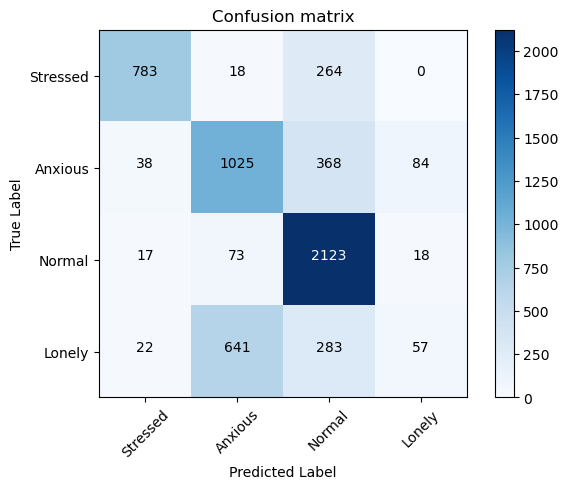

In [55]:
# Looking at the Confusion Matrix
#Hash Vectorizer with Linear SVM
labels = ['Stressed', 'Anxious', 'Normal', 'Lonely']

classifier = SGDClassifier(loss='hinge',alpha = 0.001, penalty='l2', random_state=42, max_iter=5, tol=None)
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('accuracy: %.3f'%score)
cm = metrics.confusion_matrix(y_test, pred, labels=labels)

plot_confusion_matrix(cm, classes=labels)

In [54]:
print(cm)

[[ 783   18  264    0]
 [  38 1025  368   84]
 [  17   73 2123   18]
 [  22  641  283   57]]


/Users/lynnpowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.678
confusion matrix, without normalization


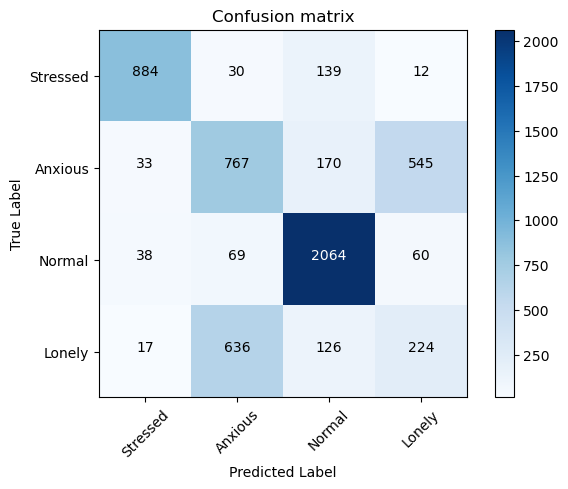

In [56]:
# Looking at the Confusion Matrix
#Hash Vectorizer with Logistic Regression
labels = ['Stressed', 'Anxious', 'Normal', 'Lonely']

classifier = LogisticRegression(n_jobs=1, C=1)
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print('accuracy: %.3f'%score)
cm = metrics.confusion_matrix(y_test, pred, labels=labels)

plot_confusion_matrix(cm, classes=labels)

In [57]:
#save results
#results_file_path = '/Users/lynnpowell/Documents/DS_Projects/Tweet_Mental_Health_Classifier/'
#df_results.to_csv(results_file_path+'Tweet_ML_Accuracy_Results.csv',index=False)

In [58]:
# Removing special characters from text in title column -> test data frame (df_test)
# Removing stop words: and, it, ... (don't have much importance)

ps = PorterStemmer()
corpus_test = []

for i in range(0, len(df_test)):
    #replacing any character that is not a/A through z/Z with a blank - used for split
    tweet = re.sub('[^a-zA-Z]', ' ', df_test['tweets'][i])
    #uniforms the list to make it easier to go threw each word
    tweet = tweet.lower()
    #split -> each word in to a list
    tweet = tweet.split()
    
    #checking each character for stem and stopwords
    #removing the stop words then performing the steming process
    tweet = [ps.stem(word) for word in tweet if not word in stopwords.words('english')]
    tweet = ' '.join(tweet)
    corpus_test.append(tweet)
    

In [61]:
#Generating Submission file
#Using Hash Vectorizer with Linear SVM

#using the Hash Vectorizer method on the cleaned test tweets
hs_vector = HashingVectorizer(n_features=5000, alternate_sign=False)
df_test_X = hs_vector.fit_transform(corpus_test).toarray()

#Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    
classifier = SGDClassifier(loss='hinge',alpha = 0.001, penalty='l2', random_state=42, max_iter=5, tol=None)
classifier.fit(X_train,y_train)
label_predictions = classifier.predict(df_test_X)
label_predictions[:5]

array(['Anxious', 'Anxious', 'Normal', 'Stressed', 'Anxious'], dtype='<U8')

In [63]:
#save model accuracy results
results_file_path = '/Users/lynnpowell/Documents/DS_Projects/Tweet_Mental_Health_Classifier/'
scores_df.to_csv(results_file_path+'Tweet_ML_Accuracy_Results.csv',index=False)

In [64]:
#Formating results for Kaggle Submission
test_tweet_ids = df_test['id']
submission = {'id': test_tweet_ids,
                 'labels': label_predictions}
submission_df = pd.DataFrame(submission)
submission_df.to_csv(results_file_path+'Tweet_Mental_Health_Submission.csv',index=False)
submission_df.head()

,id,labels
0,0,Anxious
1,1,Anxious
2,2,Normal
3,3,Stressed
4,4,Anxious


#### Submission to Kaggle Competition:

- Model Accuracy Score: 0.62613
- No position on the leaderboard since the competition has already been closed.